# 고객 세분화(Customer Segmentation) 하기

- 해당 문제는 다음 [Kaggle dataset](https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset) 을 활용하였습니다.

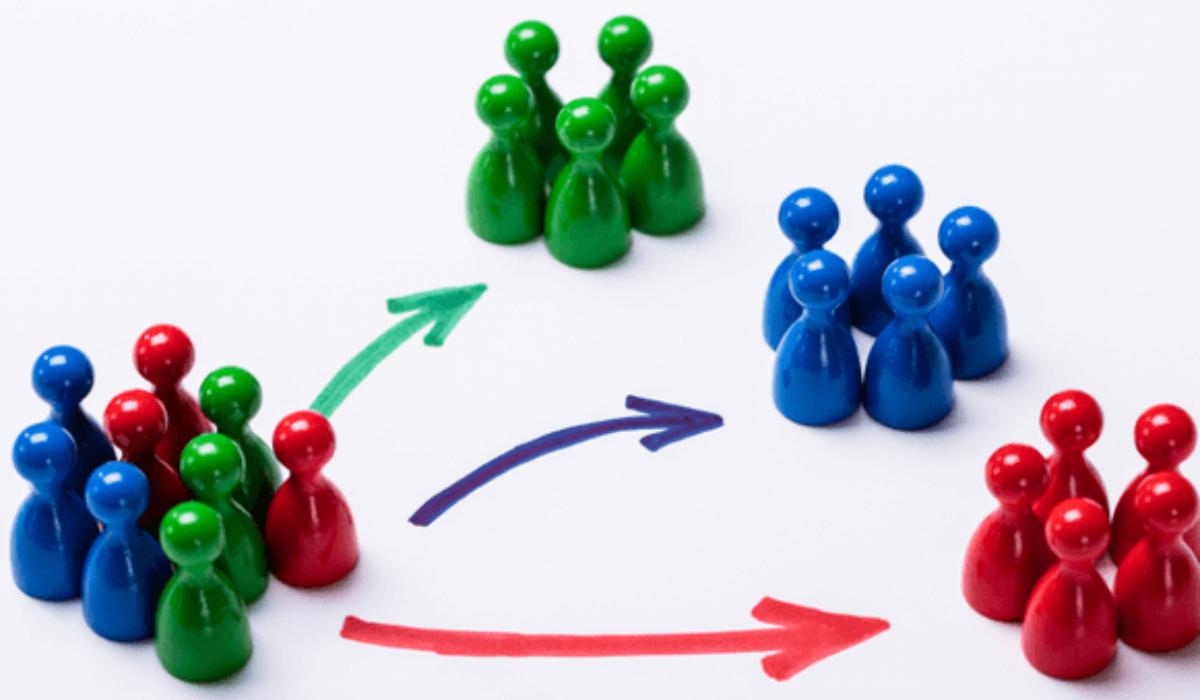

### 1.라이브러리 임포트

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import gdown

### 2.데이터셋 로드 및 전처리

In [ ]:
# Google Sheets 파일의 URL
url = 'https://docs.google.com/spreadsheets/d/1RE-6XHfBhA5HqlpWiarFzOQ6N6kGBAJQ/export?format=xlsx'
# 파일을 다운로드 받을 경로
output = 'Online_Retail.xlsx'

# 파일 다운로드
gdown.download(url, output, quiet=False)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1RE-6XHfBhA5HqlpWiarFzOQ6N6kGBAJQ/export?format=xlsx
To: /content/Online_Retail.xlsx
23.7MB [00:00, 53.7MB/s]


'Online_Retail.xlsx'

In [ ]:
df = pd.read_excel(output) # excel file 읽어오기
df.head()

### 3.EDA 및 F.E

In [ ]:
# 필요한 피처를 선택하고 결측치 제거
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
# 고객별 총 구매금액(TotalPurchase)과 구매건수(PurchaseCount) 계산
df['TotalPurchase'] = df['Quantity'] * df['UnitPrice'] # Quantity * UnitPrice
customer_data = df.groupby('CustomerID').agg({
    'TotalPurchase': 'sum',
    'InvoiceNo': 'nunique'
}).rename(columns={'InvoiceNo': 'PurchaseCount'}).reset_index()

In [ ]:
customer_data.head()

,CustomerID,TotalPurchase,PurchaseCount
0,12346.0,0.00,2
1,12347.0,4310.00,7
2,12348.0,1797.24,4
3,12349.0,1757.55,1
4,12350.0,334.40,1


In [ ]:
customer_data.tail()

,CustomerID,TotalPurchase,PurchaseCount
4367,18280.0,180.60,1
4368,18281.0,80.82,1
4369,18282.0,176.60,3
4370,18283.0,2094.88,16
4371,18287.0,1837.28,3


In [ ]:
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data[['TotalPurchase','PurchaseCount']])

In [ ]:
X_scaled

array([[-0.23100099, -0.32936215],
       [ 0.29343167,  0.20610242],
       [-0.01231622, -0.11517632],
       ...,
       [-0.20951263, -0.22226923],
       [ 0.02390005,  1.16993863],
       [-0.00744423, -0.22226923]])

### 4.모델 로드 및 학습

In [ ]:
# KMeans 클러스터링 모델 사용
kmeans = KMeans(n_clusters=5, random_state=42,n_init=10) # warning message읽고 n_init 추가하기
kmeans.fit(X_scaled)

KMeans(n_clusters=5, n_init=10, random_state=42)

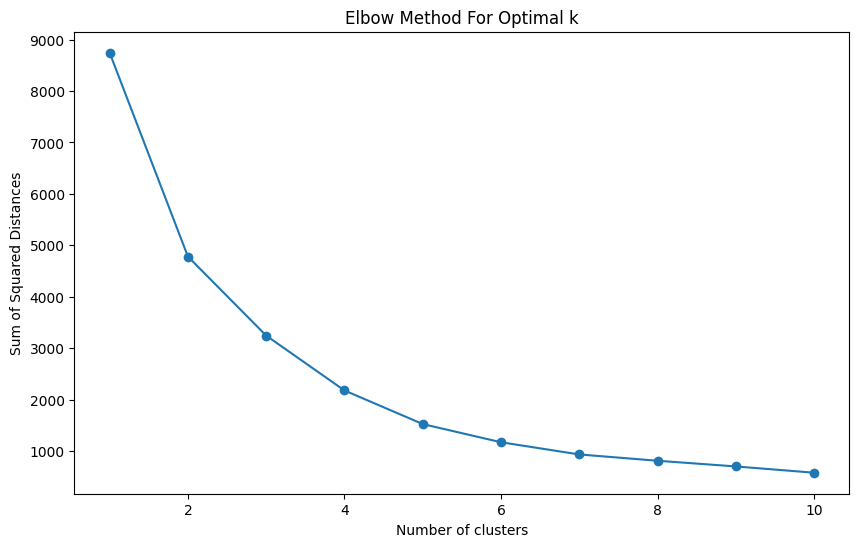

In [ ]:
# 4. 최적의 클러스터 수 결정 - 엘보우 법칙
sse = []
range_n_clusters = list(range(1, 11))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# 엘보우 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

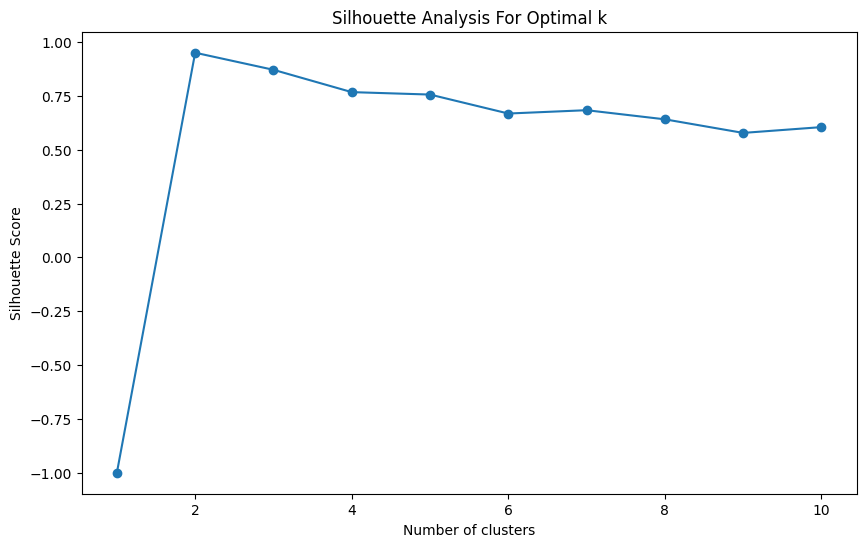

In [ ]:
# 4. 최적의 클러스터 수 결정 - 실루엣 계수
silhouette_avg = []
for n_clusters in range_n_clusters:
    if n_clusters == 1:
        silhouette_avg.append(-1)  # 클러스터가 1개일 때는 실루엣 계수를 계산할 수 없음
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
        kmeans.fit(X_scaled)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(X_scaled,cluster_labels)) # X 값과 클러스터링 결과 사이에 구하기

# 실루엣 계수 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Analysis For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# 최적의 클러스터 수를 선택하여 모델 재학습
optimal_clusters = 5  # 엘보우 법칙 및 실루엣 계수를 기반으로 결정된 최적의 클러스터 수
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42,n_init=10)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, n_init=10, random_state=42)

QuiZ : 실루엣 점수는 각 포인트에 대해서 계산되는 과정 찾아보기 정리하기

`from sklearn.metrics import silhouette_score`

=> 더 잘 비교하고 싶은 니즈와 왜 클러스터 5가 최적인 지에 대한 궁금증!

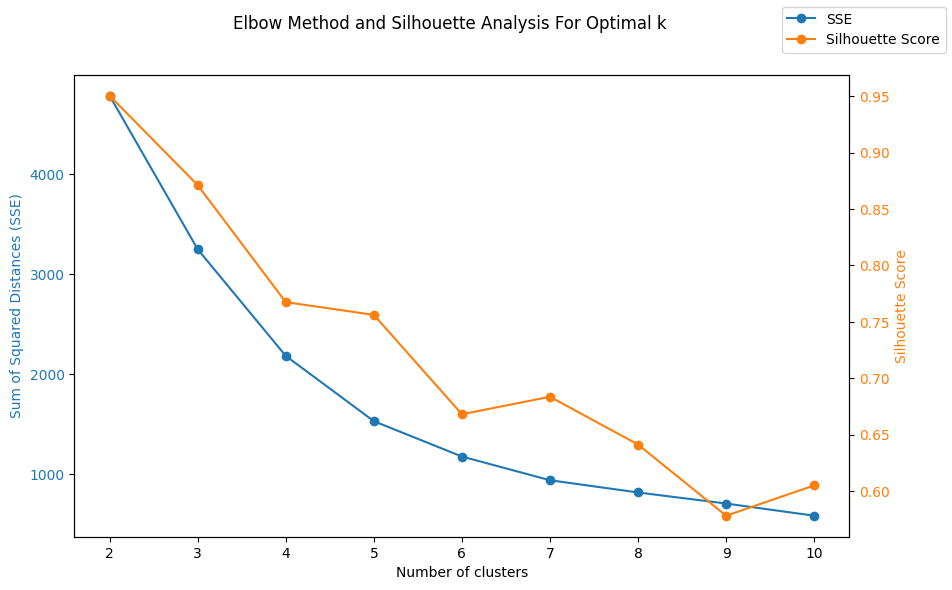

Optimal number of clusters based on composite score: 5
Final chosen number of clusters: 5


In [ ]:
# 최적의 클러스터 수 결정 - 엘보우 법칙 및 실루엣 계수
sse = []
silhouette_avg = []
range_n_clusters = list(range(2, 11))  # 클러스터 수는 최소 2개부터 시작
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

# 두 지표를 모두 고려하는 그래프 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 엘보우 법칙에 따른 SSE
color = 'tab:blue'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Sum of Squared Distances (SSE)', color=color)
ax1.plot(range_n_clusters, sse, marker='o', color=color, label='SSE')
ax1.tick_params(axis='y', labelcolor=color)

# 실루엣 계수
ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 쌍둥이 축
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range_n_clusters, silhouette_avg, marker='o', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 제목 설정
fig.suptitle('Elbow Method and Silhouette Analysis For Optimal k')

# 범례 설정
fig.legend(loc='upper right')

# 그래프 표시
plt.show()

# 두 지표의 정규화
sse_norm = MinMaxScaler().fit_transform(np.array(sse).reshape(-1, 1)).flatten()
silhouette_norm = MinMaxScaler().fit_transform(np.array(silhouette_avg).reshape(-1, 1)).flatten()

# 두 지표의 복합 점수 계산 (SSE는 낮을수록 좋기 때문에 1에서 빼줌)
composite_score = (1 - sse_norm) + silhouette_norm

# 최적의 클러스터 수 결정
optimal_clusters = range_n_clusters[np.argmax(composite_score)]
print(f"Optimal number of clusters based on composite score: {optimal_clusters}")

# 최적의 클러스터 수를 선택하여 모델 재학습
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_scaled)

print(f"Final chosen number of clusters: {optimal_clusters}")

In [ ]:
composite_score

array([1.        , 1.15266638, 1.12800415, 1.25311385, 1.10068962,
       1.19868485, 1.11411359, 0.97096922, 1.07217692])

In [ ]:
np.argmax(composite_score)

3

In [ ]:
range_n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
silhouette_avg.index(max(silhouette_avg))

2

In [ ]:
silhouette_score(X_scaled, cluster_labels)

0.6048839157080382

### 5.모델 평가 및 예측

In [ ]:
# 클러스터링 결과 레이블 가져오기
customer_data['Cluster'] = kmeans.labels_
print(kmeans.labels_)
# 각 클러스터의 중심 좌표
centers = kmeans.cluster_centers_
print(centers)

[0 0 0 ... 0 4 0]
[[-0.12102175 -0.21149431]
 [ 5.11242458  5.83401962]
 [ 7.96140365 22.33863769]
 [29.11003993  6.38179371]
 [ 0.50937422  1.36072173]]


### 6.모델 결과 시각화

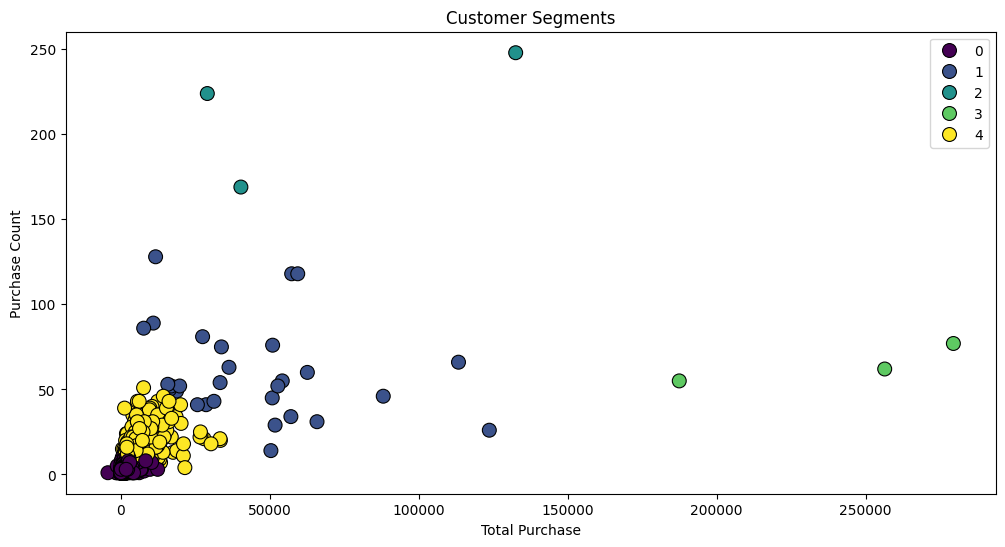

In [ ]:
# 클러스터링 결과 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TotalPurchase', y='PurchaseCount', hue='Cluster', data=customer_data, palette='viridis', s=100, edgecolor='k')
plt.title('Customer Segments')
plt.xlabel('Total Purchase')
plt.ylabel('Purchase Count')
plt.legend()
plt.show()

<ipython-input-29-8136a5f301c4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=customer_data, palette='viridis')


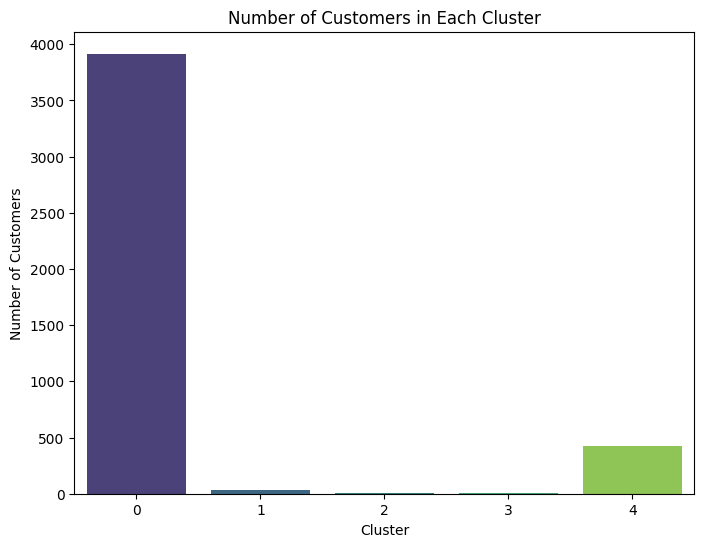

In [ ]:
# 각 클러스터에 속하는 고객 수 시각화
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=customer_data, palette='viridis')
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()